In [ ]:
!pip install opendatasets

In [ ]:
import pandas as pd
import opendatasets as od

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: glzadeevni
Your Kaggle Key: ··········


100%|██████████| 3.69G/3.69G [00:31<00:00, 126MB/s] 


In [ ]:
import json
import os
import math
import librosa

In [ ]:

DATASET_PATH = "/content/drive/MyDrive/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO"
JSON_PATH = "new_data.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)




In [ ]:
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [ ]:


DATA_PATH = "/content/new_data.json"


def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(2, activation='softmax'))

    return model


def predict(model, X, y):

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 6, 32)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 6, 32)         128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 2, 32)         0         
 g2D)                                                            
                                                        

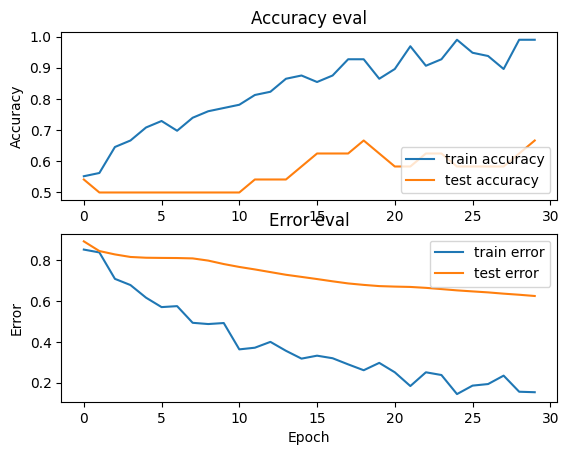

2/2 - 0s - loss: 0.6264 - accuracy: 0.7000 - 224ms/epoch - 112ms/step

Test accuracy: 0.699999988079071


IndexError: index 100 is out of bounds for axis 0 with size 40

In [ ]:
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    #input_shape = (X_train.shape[1], X_train.shape[2], 1)
    input_shape = (130, 13, 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

     # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)



In [ ]:
# Modeli kaydetme
model.save("/content/cnn_new_audio.h5")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 6, 32)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 6, 32)         128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 2, 32)         0         
 g2D)                                                            
                                                        

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
import tensorflow as tf

In [ ]:
def predict_genre(model, audio_file_path, genre_mapping):

    # Load audio file
    signal, sample_rate = librosa.load(audio_file_path, sr=SAMPLE_RATE)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T

    # Reshape MFCCs to match model input shape
    mfcc = mfcc[:130, ...]  # Take only the first 130 MFCCs
    mfcc = mfcc[np.newaxis, ..., np.newaxis]  # Add extra dimensions


    # Predict using the model
    prediction = model.predict(mfcc)
    predicted_index = np.argmax(prediction, axis=1)

    # Map predicted index to genre label
    genre_label = genre_mapping[predicted_index[0]]
    print("Raw prediction:", prediction)

    return genre_label

# Load your trained model
model_path = "/content/cnn_new_audio.h5"
model = load_model(model_path)

# Path to the audio file you want to predict
audio_file_path = "/content/drive/MyDrive/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

# Genre mapping (update this according to your dataset)
genre_mapping = {0: "real", 1: "fake"}

# Make the prediction
predicted_genre = predict_genre(model, audio_file_path, genre_mapping)

print("Predicted genre:", predicted_genre)

1/1 [==============================] - 0s 121ms/step
Raw prediction: [[0.6990629 0.3009371]]
Predicted genre: real
